# **Proyek Recommendations System: [Anime Recommendations Database]**

- **Nama:** Satria Dirgantara Nurayaman
- **Email:** satriadirgantaranuryaman@gmail.com
- **ID Dicoding:** Satria Dirgantara Nuryaman

## **Import Library**

In [1]:
# Manipulation Data
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reccommender System
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# TensorFlow
import tensorflow as tf

# Configurations
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

## **Data Loading**

In [2]:
# Load Anime.csv file
anime_df = pd.read_csv('Data/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [26]:
# Load Rating.csv file
rating_df = pd.read_csv('Data/rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [27]:
# Ambil sample 100.000 baris secara acak
df_sample = rating_df.sample(n=100000, random_state=42)

# Simpan file ke data
df_sample.to_csv('Data/rating_sample.csv', index=False)

- Disini karena data rating.csv asli berukuran lebih dari 100mb maka aku memutuskan untuk melakukan sampling data sebanyak 100.000 baris, agar bisa di perlihatkan pada github.

# Disini 

## **Exploratory Data Analysis (EDA)**

### **Deskripsi Variable**

**Anime.csv:**
| Kolom      | Deskripsi                                                                 |
|------------|--------------------------------------------------------------------------|
| anime_id   | ID unik untuk setiap anime (mengacu pada myanimelist.net)                |
| name       | Nama lengkap anime                                                       |
| genre      | Daftar genre anime, dipisahkan koma                                      |
| type       | Tipe anime (TV, Movie, OVA, dll)                                         |
| episodes   | Jumlah episode (1 jika movie)                                            |
| rating     | Rata-rata rating dari seluruh user (skala 1-10)                          |
| members    | Jumlah anggota komunitas yang memasukkan anime ini ke dalam grup mereka  |

**Rating.csv**
| Kolom    | Deskripsi                                                                 |
|----------|--------------------------------------------------------------------------|
| user_id  | ID unik pengguna (acak, tidak dapat diidentifikasi)                      |
| anime_id | ID anime yang dirating oleh user (mengacu pada anime_id di anime.csv)    |
| rating   | Nilai rating yang diberikan user (skala 1-10, -1 jika tidak memberi rating)|

### **Informasi Umum**

In [4]:
# Informasi singkat tentang dataset anime
print(f'Jumlah Baris dan Kolom anime_df adalah: {anime_df.shape}')
print(f'\n Informasi Tentang Dataset Anime :')

# Menampilkan informasi dasar
anime_df.info()

Jumlah Baris dan Kolom anime_df adalah: (12294, 7)

 Informasi Tentang Dataset Anime :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Berdasarkan hasil eksplorasi awal: 
- Dataset anime terdiri dari **12.294** baris dan **7** fitur utama. 
- Dataset ini juga terdiri dari **3** fitur bertipe data numerik seperti `anime_id`, `rating`, dan juga `members`, dan **4** bertipe data object seperti `name`, `genre`, `type`, dan juga `episodes`.
- Sebagian besar data sudah lengkap, namun terdapat beberapa nilai kosong pada kolom `genre`, `type`, dan `rating`. Hal ini perlu diperhatikan pada tahap data preparation agar tidak mempengaruhi hasil rekomendasi. 

Secara umum, dataset ini sudah sangat representatif untuk membangun sistem rekomendasi berbasis konten dan kolaboratif.

In [5]:
# Informasi singkat tentang dataset rating
print(f'Jumlah Baris dan Kolom rating_df adalah: {rating_df.shape}')
print(f'\nInformasi Tentang Dataset Rating :')

# Menampilkan informasi dasar
rating_df.info()

Jumlah Baris dan Kolom rating_df adalah: (7813737, 3)

Informasi Tentang Dataset Rating :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Berdasarkan hasil eksplorasi awal ditemukan bahwa:
- Dataset rating terdiri dari **7.813.737** baris dan **3** fitur utama, yaitu user_id, anime_id, dan rating. Seluruh data pada rating.csv bertipe numerik dan tidak ditemukan nilai kosong. 
- Tapi, jumlah data yang sangat besar ini dapat menimbulkan tantangan komputasi, terutama pada proses training model collaborative filtering. 

Jika nanti proses komputasi sangat lambat, maka rencananya kita bakal mengambil sebanyak **1 - 2 juta sampel saja**.

### **Ringkasan Statistik**

In [6]:
# Ringkasan statistik deskriptif untuk anmie_df
print('\nStatistik Deskriptif untuk anime_df:')

# Fitur Numerik
print('\nFitur Numerik:')
display(anime_df.describe())

# Fitur Kategorikal
print('\nFitur Kategorikal:')
display(anime_df.describe(include='object'))


Statistik Deskriptif untuk anime_df:

Fitur Numerik:


,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06



Fitur Kategorikal:


,name,genre,type,episodes
count,12294,12232,12269,12294
unique,12292,3264,6,187
top,Shi Wan Ge Leng Xiaohua,Hentai,TV,1
freq,2,823,3787,5677


Dari ringkasan statistik dataset `anime_df`, terdapat beberapa hal menarik yang dapat dicatat:

- Untuk fitur numerik:
  - **Rating** anime memiliki rata rata **6.47** dari skala **10**, dengan nilai minimum **1.67** dan maksimum **10.0**, menunjukkan adanya sebaran kualitas dari yang sangat rendah hingga sangat tinggi.
  - **Members**, yang merepresentasikan popularitas, sangat bervariasi, dengan median sebesar **1.550** ribu, namun ada anime yang mencapai lebih dari **1 juta anggota**, menunjukkan distribusi yang sangat tidak merata (right-skewed).
  
- Untuk fitur kategorikal:
  - Terdapat **12.292 judul anime unik** dari **12.294 data**, menunjukkan nyaris tidak ada duplikasi nama.
  - Genre paling sering muncul adalah **Hentai**, dengan **823 kemunculan**, sedangkan jenis penayangan paling dominan adalah **TV** (3787 data).
  - Fitur `episodes` memiliki **187 nilai unik**, dengan episode `1` paling umum muncul (5677 kali), mengindikasikan bahwa pengguna sering menonton anime Movie atau mungkin OVA dan Special Episode.

Secara keseluruhan, dataset ini merepresentasikan dunia anime dengan sangat beragam, baik dari segi rating, popularitas, genre, hingga format tayangan.

In [7]:
# Ringkasan statistik dari dataset rating_df
print('\nStatistik Deskriptif untuk rating_df:')
rating_df.describe()


Statistik Deskriptif untuk rating_df:


,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Dari ringkasan statistik deskriptif rating_df kita menemukan:

- Dataset ini mencatat lebih dari **7,8 juta interaksi** antara pengguna dan anime. Rata rata rating berada di angka **6.14**, dengan median **7.0**, menandakan kecenderungan pengguna atau penonton memberi nilai cukup positif. 

- Nilai rating berkisar dari **-1 hingga 10**, di mana **-1** kemungkinan besar berarti belum memberikan penilaian. Penyebaran rating cukup lebar, dengan standar deviasi **3.72**, menunjukkan adanya variasi opini yang tinggi. 

Secara keseluruhan, data ini menggambarkan sistem rating yang aktif dan sangat bervariasi, pondasi yang sangat kaya untuk membangun sistem rekomendasi.

### **Identifikasi Missing Values dan Duplikasi**

In [8]:
# Identifikasi Missing Values dan Duplikasi anime_df
missing_values_anime = anime_df.isnull().sum()
missing_values_anime_percentage = (missing_values_anime / len(anime_df)) * 100
duplicates_anime = anime_df.duplicated().sum()

# Membuat DataFrame untuk missing_anime_df
missing_anime_df = pd.DataFrame({
    'Jumlah Missing Values': missing_values_anime,
    'Persentasi Missing Values': missing_values_anime_percentage,
    'Jumlah Duplikasi': duplicates_anime
}).sort_values(by='Jumlah Missing Values', ascending=False)

# Menampilkan DataFrame missing_anime_df
display(missing_anime_df)

,Jumlah Missing Values,Persentasi Missing Values,Jumlah Duplikasi
rating,230,1.870831,0
genre,62,0.504311,0
type,25,0.203351,0
anime_id,0,0.000000,0
name,0,0.000000,0
episodes,0,0.000000,0
members,0,0.000000,0


- Secara keseluruhan, dataset `anime_df` tergolong bersih. Hanya terdapat sedikit missing values pada kolom `rating` (1.87%), `genre` (0.50%), dan `type` (0.20%). Sisanya lengkap 100%.
- Tidak ditemukan **data duplikat** di seluruh kolom, termasuk `anime_id` dan `name`, yang berarti tiap entri mewakili satu anime yang unik.



In [9]:
# Identifikasi Missing Values dan Duplikasi rating_df
missing_values_anime = rating_df.isnull().sum()
missing_values_anime_percentage = (missing_values_anime / len(rating_df)) * 100
duplicates_anime = rating_df.duplicated().sum()

# Membuat DataFrame untuk missing_rating_df
missing_rating_df = pd.DataFrame({
    'Jumlah Missing Values': missing_values_anime,
    'Persentasi Missing Values': missing_values_anime_percentage,
    'Jumlah Duplikasi': duplicates_anime
}).sort_values(by='Jumlah Missing Values', ascending=False)

# Menampilkan DataFrame missing_rating_df
display(missing_rating_df)

,Jumlah Missing Values,Persentasi Missing Values,Jumlah Duplikasi
user_id,0,0.0,1
anime_id,0,0.0,1
rating,0,0.0,1


- Dataset rating_df sangat bersih, tidak ada missing values yang teridentifikasi, tapi hanya aja duplikasi data saja dengan jumlah hanya 1.

### **Univariate Visualization**

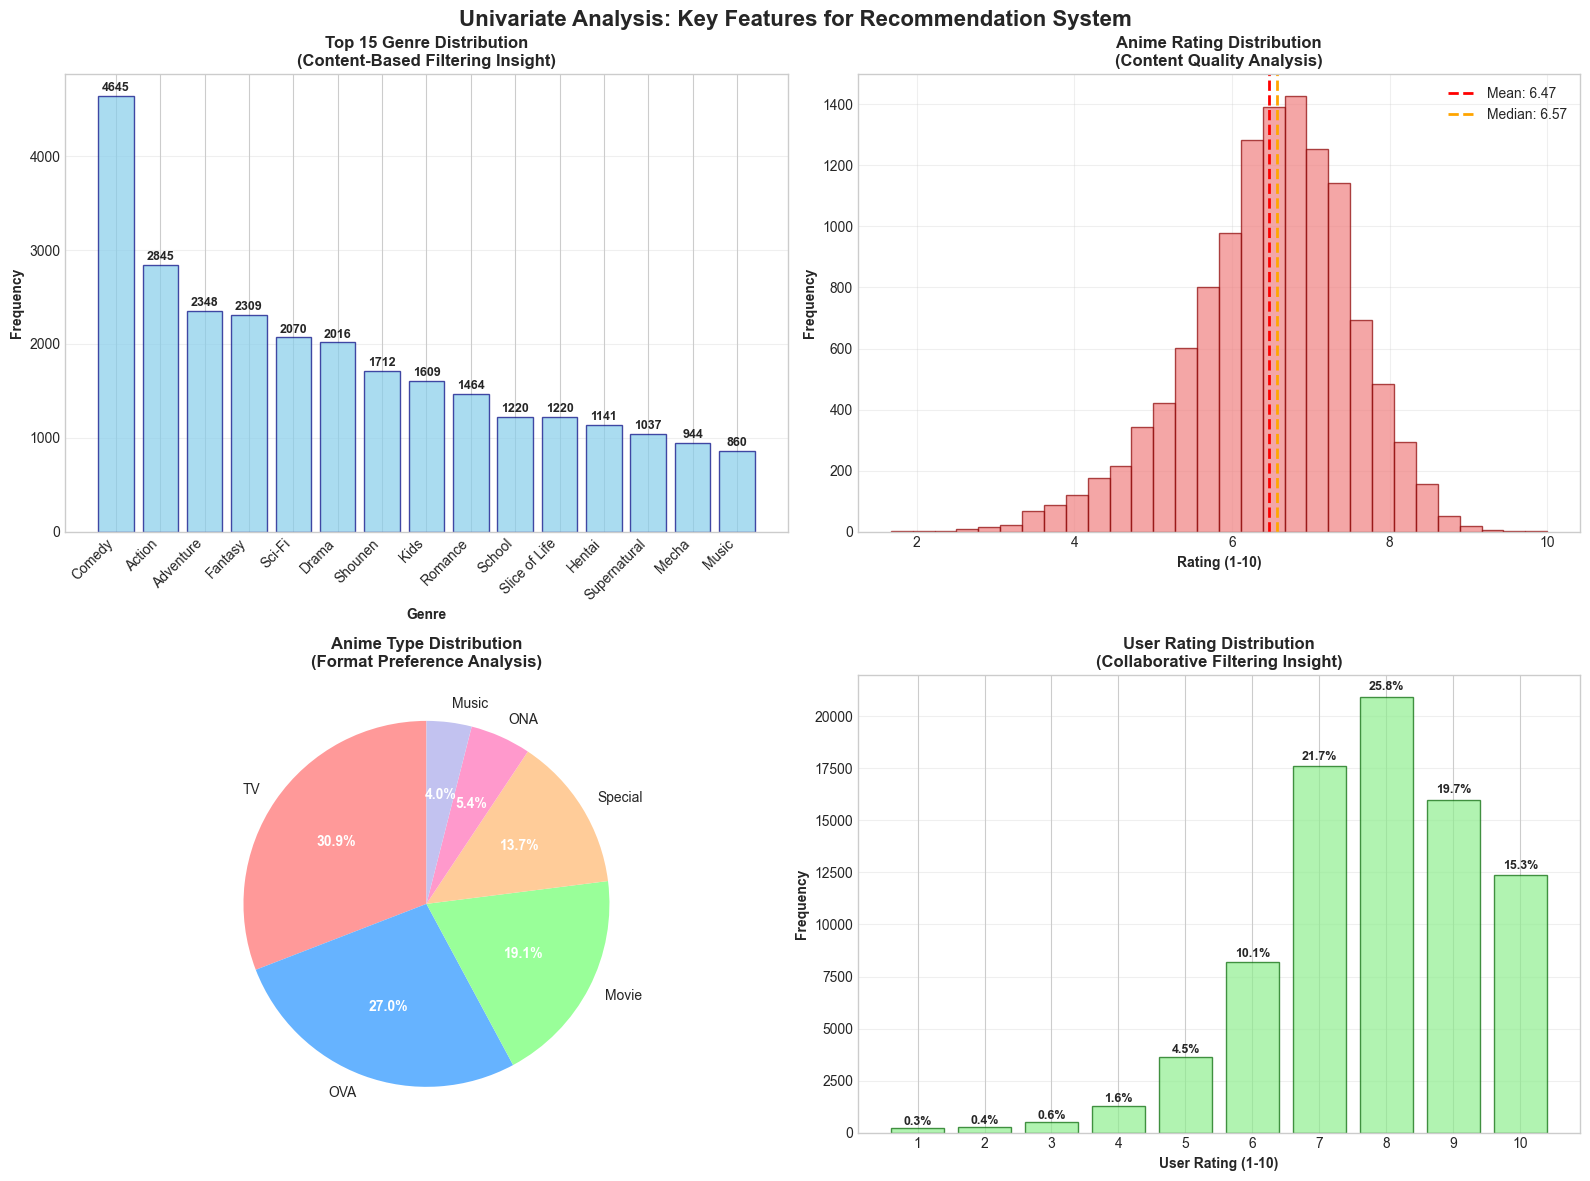

KEY INSIGHTS DARI UNIVARIATE ANALYSIS VISUALIZATION
- Total Keragaman Genre: 43 Nilai Unik
- Genre Paling Populer: Comedy (4645 anime)
- Rata rata rating anime: 6.47/10
- Preferensi Rating Pengguna: 7.81 rata rata
- Rating Users Paling Umum: 8/10
- Rating distribution skew: Positive bias
- Tipe Paling Umum: TV (3787 anime)


In [12]:
# Univariate Visualization - 4 Visualisasi Kunci untuk Recommendation System

# Setup figure dengan 4 subplot
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Univariate Analysis: Key Features for Recommendation System', fontsize=16, fontweight='bold')

# Preprocessing genre data
all_genres = []
for genres in anime_df['genre'].dropna():
    genre_list = [g.strip() for g in str(genres).split(',')]
    all_genres.extend(genre_list)

genre_counts = pd.Series(all_genres).value_counts().head(15)

# 1. Top 15 Genre Distribution - Content-Based Filtering Insight
bars = ax[0, 0].bar(range(len(genre_counts)), genre_counts.values, color='skyblue', edgecolor='navy', alpha=0.7)
ax[0, 0].set_title('Top 15 Genre Distribution\n(Content-Based Filtering Insight)', fontweight='bold', fontsize=12)
ax[0,0].set_xlabel('Genre', fontweight='bold')
ax[0,0].set_ylabel('Frequency', fontweight='bold')
ax[0,0].set_xticks(range(len(genre_counts)))
ax[0,0].set_xticklabels(genre_counts.index, rotation=45, ha='right')

# Menambahkan annotasi di atas bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax[0,0].text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax[0,0].grid(axis='y', alpha=0.3)

# 2. Distribusi Rating Anime - Kualitas Konten

ax[0, 1].hist(anime_df['rating'].dropna(), bins=30, color='lightcoral', edgecolor='darkred', alpha=0.7)
ax[0, 1].axvline(anime_df['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {anime_df["rating"].mean():.2f}')
ax[0, 1].axvline(anime_df['rating'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {anime_df["rating"].median():.2f}')
ax[0, 1].set_title('Anime Rating Distribution\n(Content Quality Analysis)', fontweight='bold', fontsize=12)
ax[0, 1].set_xlabel('Rating (1-10)', fontweight='bold')
ax[0, 1].set_ylabel('Frequency', fontweight='bold')
ax[0, 1].legend()
ax[0, 1].grid(alpha=0.3)

# 3. Distribusi Type Anime
type_counts = anime_df['type'].value_counts()
wedges, texts, autotexts = ax[1, 0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
                                   startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0'])
ax[1, 0].set_title('Anime Type Distribution\n(Format Preference Analysis)', fontweight='bold', fontsize=12)

# Styling pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. Distribusi User Ratings (dari rating_df) - Collaborative Filtering Insight
# Mengambil sample untuk performa (100k data)
rating_sample = rating_df.sample(n=100000, random_state=42)
user_rating_dist = rating_sample[rating_sample['rating'] != -1]['rating']


bars4 = ax[1, 1].bar(user_rating_dist.value_counts().sort_index().index, 
               user_rating_dist.value_counts().sort_index().values, 
               color='lightgreen', edgecolor='darkgreen', alpha=0.7)
ax[1, 1].set_title('User Rating Distribution\n(Collaborative Filtering Insight)', fontweight='bold', fontsize=12)
ax[1, 1].set_xlabel('User Rating (1-10)', fontweight='bold')
ax[1, 1].set_ylabel('Frequency', fontweight='bold')
ax[1, 1].set_xticks(range(1, 11))

# Antonasi di atas bar
total_ratings = len(user_rating_dist)
for bar in bars4:
    height = bar.get_height()
    percentage = (height / total_ratings) * 100
    ax[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tampilkan insights penting
print('='*60)
print('KEY INSIGHTS DARI UNIVARIATE ANALYSIS VISUALIZATION')
print('='*60)
print(f'- Total Keragaman Genre: {len(pd.Series(all_genres).unique())} Nilai Unik')
print(f'- Genre Paling Populer: {genre_counts.index[0]} ({genre_counts.iloc[0]} anime)')
print(f'- Rata rata rating anime: {anime_df["rating"].mean():.2f}/10')
print(f'- Preferensi Rating Pengguna: {user_rating_dist.mean():.2f} rata rata')
print(f'- Rating Users Paling Umum: {user_rating_dist.mode().iloc[0]}/10')
print(f'- Rating distribution skew: {"Positive bias" if user_rating_dist.mean() > 5.5 else "Negative bias"}')
print(f'- Tipe Paling Umum: {type_counts.index[0]} ({type_counts.iloc[0]} anime)')




Dari keempat visualisasi yang dilakukan di atas dan key insight yang diperoleh, kita menemukan bahwa:

- Preferensi pengguna terhadap konten anime sangat tercermin dari dominasi genre **_Comedy_**, yang menempati posisi teratas secara signifikan. Hal ini menunjukkan kecenderungan penonton terhadap tontonan yang **ringan dan menghibur**. Sementara itu, distribusi rating anime menunjukkan pola yang cukup seimbang, dengan **rata rata 6.47** dan **median 6.57**, mengindikasikan bahwa sebagian besar anime dinilai **cukup layak oleh komunitas**. Format **TV** menjadi tipe paling umum, menegaskan bahwa **serial** masih menjadi pilihan utama dalam industri anime dibanding format seperti OVA atau Movie.

- Dari sisi **interaksi pengguna**, rating yang diberikan menunjukkan kecenderungan yang **sangat positif**, dengan nilai **8/10** menjadi yang paling sering diberikan. Ini mengindikasikan adanya **bias positif** dalam perilaku pengguna, di mana mereka cenderung menilai lebih tinggi anime yang mereka tonton. Distribusi seperti ini memberi sinyal penting bagi pengembangan **sistem rekomendasi**, di mana **genre populer** dan **anime dengan rating tinggi** dapat menjadi **titik awal** dalam memberikan saran yang lebih **relevan dan memuaskan**.

### **Multivariate Visualization**

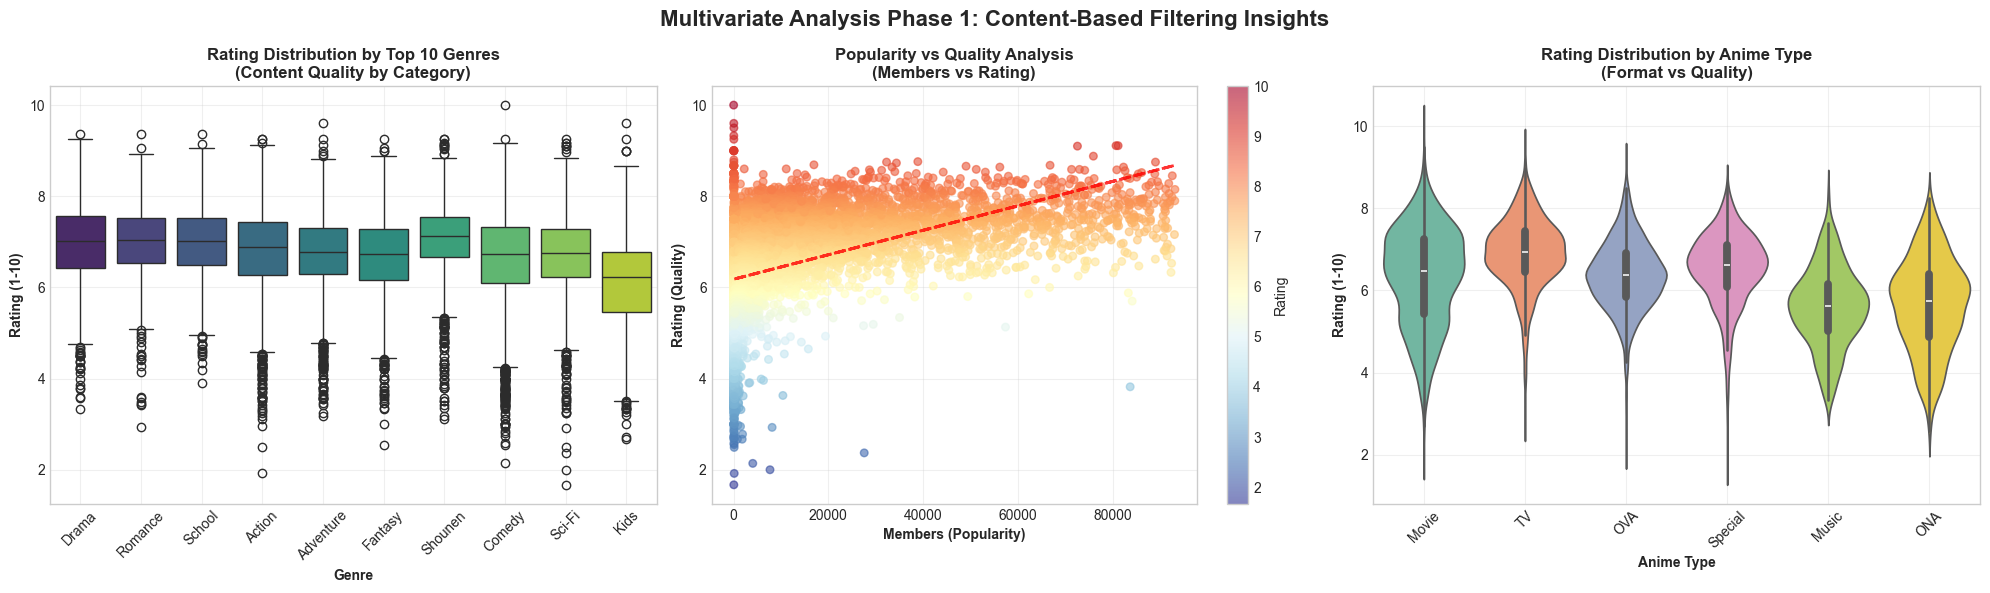

PHASE 1 MULTIVARIATE ANALYSIS INSIGHTS
Korelasi Popularitas - Kualitas: 0.388
Genre Rating Tertinggi: Shounen (rata rata: 7.06)
Genre Rating Terendah: Kids (rata rata: 6.11)
Tipe Terbaik berdasarkan Rating: TV (rata rata: 6.90)


In [ ]:
# Setup figure dengan 3 subplot untuk Phase 1 Analysis
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Multivariate Analysis Phase 1: Content-Based Filtering Insights', fontsize=16, fontweight='bold')

# 1. Rating vs Genre Analysis (Boxplot)
# Preprocessing: Ambil top 10 genre untuk clarity
all_genres = []
anime_genre_mapping = []

for idx, genres in anime_df['genre'].dropna().items():
    genre_list = [g.strip() for g in str(genres).split(',')]
    for genre in genre_list:
        anime_genre_mapping.append({
            'anime_id': anime_df.loc[idx, 'anime_id'],
            'genre': genre,
            'rating': anime_df.loc[idx, 'rating']
        })

genre_rating_df = pd.DataFrame(anime_genre_mapping)
top_genres = genre_rating_df['genre'].value_counts().head(10).index

# Filter untuk top 10 genres
genre_rating_filtered = genre_rating_df[genre_rating_df['genre'].isin(top_genres)]

# Plot 1: Rating Distribution by Genre
sns.boxplot(data=genre_rating_filtered, x='genre', y='rating', ax=ax[0], palette='viridis')
ax[0].set_title('Rating Distribution by Top 10 Genres\n(Content Quality by Category)', fontweight='bold', fontsize=12)
ax[0].set_xlabel('Genre', fontweight='bold')
ax[0].set_ylabel('Rating (1-10)', fontweight='bold')
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(alpha=0.3)

# 2. Members vs Rating Correlation (Scatterplot)
# Filter outliers untuk visualization yang lebih baik
anime_filtered = anime_df[(anime_df['members'] < anime_df['members'].quantile(0.95)) & 
                         (anime_df['rating'].notna())]

scatter = ax[1].scatter(anime_filtered['members'], anime_filtered['rating'], 
                       alpha=0.6, c=anime_filtered['rating'], cmap='RdYlBu_r', s=30)
ax[1].set_title('Popularity vs Quality Analysis\n(Members vs Rating)', fontweight='bold', fontsize=12)
ax[1].set_xlabel('Members (Popularity)', fontweight='bold')
ax[1].set_ylabel('Rating (Quality)', fontweight='bold')

# Add trendline
z = np.polyfit(anime_filtered['members'], anime_filtered['rating'], 1)
p = np.poly1d(z)
ax[1].plot(anime_filtered['members'], p(anime_filtered['members']), "r--", alpha=0.8, linewidth=2)

# Add colorbar
plt.colorbar(scatter, ax=ax[1], label='Rating')
ax[1].grid(alpha=0.3)

# 3. Type vs Rating Analysis (Violin Plot)
anime_clean = anime_df[anime_df['rating'].notna() & anime_df['type'].notna()]
sns.violinplot(data=anime_clean, x='type', y='rating', ax=ax[2], palette='Set2')
ax[2].set_title('Rating Distribution by Anime Type\n(Format vs Quality)', fontweight='bold', fontsize=12)
ax[2].set_xlabel('Anime Type', fontweight='bold')
ax[2].set_ylabel('Rating (1-10)', fontweight='bold')
ax[2].tick_params(axis='x', rotation=45)
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis Korelasi dan Insights
print('='*50)
print('PHASE 1 MULTIVARIATE ANALYSIS INSIGHTS')
print('='*50)

# Correlation analysis
correlation = anime_df[['rating', 'members']].corr().iloc[0,1]
print(f'Korelasi Popularitas - Kualitas: {correlation:.3f}')

# Genre dengan rating tertinggi
avg_rating_by_genre = genre_rating_filtered.groupby('genre')['rating'].mean().sort_values(ascending=False)
print(f'Genre Rating Tertinggi: {avg_rating_by_genre.index[0]} (rata rata: {avg_rating_by_genre.iloc[0]:.2f})')
print(f'Genre Rating Terendah: {avg_rating_by_genre.index[-1]} (rata rata: {avg_rating_by_genre.iloc[-1]:.2f})')

# Type analysis
avg_rating_by_type = anime_clean.groupby('type')['rating'].mean().sort_values(ascending=False)
print(f'Tipe Terbaik berdasarkan Rating: {avg_rating_by_type.index[0]} (rata rata: {avg_rating_by_type.iloc[0]:.2f})')

Analisis ini menunjukkan bahwa kualitas anime sangat dipengaruhi oleh genre, popularitas, dan format penyajiannya:

- Genre **Shounen** muncul sebagai kategori dengan **rating rata rata tertinggi (7.06)**. Hal ini bukan kebetulan genre ini banyak digemari karena menyajikan cerita **penuh aksi, petualangan, dan perjuangan karakter zero to hero**, seperti yang ditampilkan dalam anime legendaris **"Big Three"**: *Naruto*, *One Piece*, *Bleach* dan bapak dari "**Big Three"** yaitu *Dragon Ball*. Popularitas mereka telah merevolusi industri anime dan memperluas basis penonton secara global.

- Sebaliknya, genre **Kids** menempati posisi terbawah dengan **rating rata rata 6.11**, mencerminkan perbedaan selera dan ekspektasi antara penonton anak anak dan dewasa.

- Dari sisi format, anime bertipe **TV** menjadi yang paling unggul secara kualitas dengan **rating rata rata 6.90**, menunjukkan bahwa **serialisasi** tetap menjadi format yang paling disukai penonton dibandingkan OVA, Movie, atau lainnya.

- Terdapat pula **korelasi positif sebesar 0.388** antara jumlah **members (popularitas)** dan **rating (kualitas)**. Ini mengindikasikan bahwa anime yang **lebih populer cenderung lebih disukai**, menjadikannya aspek penting dalam sistem rekomendasi berbasis content.

Dengan demikian, **genre populer**, **format serial**, dan **tingkat popularitas** menjadi komponen kunci dalam merancang sistem rekomendasi yang efektif dan memuaskan.

Memproses sampling data untuk analisis collaborative filtering
Dataset gabungan berhasil dibuat dengan 4,054,640 interaksi user-anime


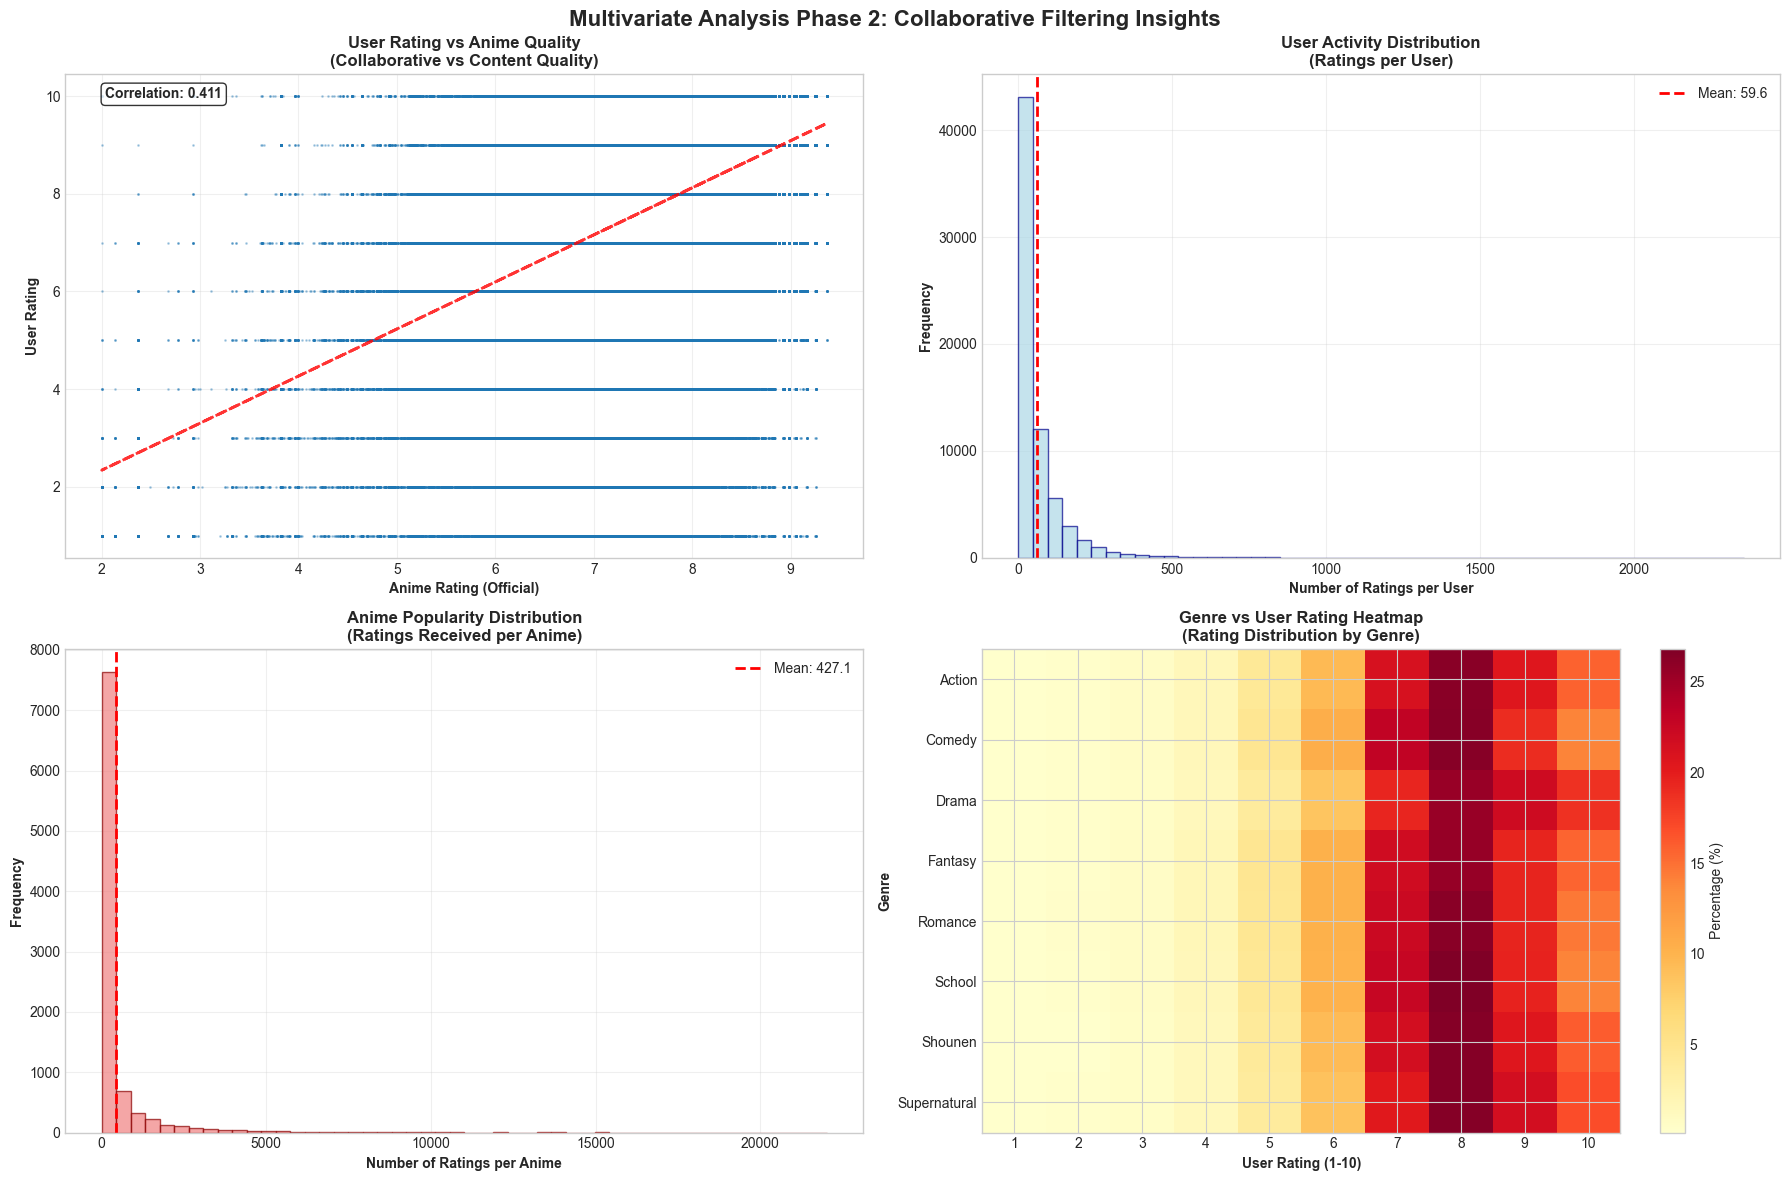

PHASE 2 COLLABORATIVE FILTERING ANALYSIS INSIGHTS
- Korelasi User Rating vs Anime Quality: 0.411
- Ratarata aktivitas user: 59.6 rating per user
- Rata rata popularitas anime: 427.1 rating per anime
- User paling aktif memberikan: 2356 rating
- Anime paling populer menerima: 22026 rating

Genre paling disukai (rating 8-10):
1. Comedy: 1,194,162 rating tinggi
2. Action: 1,064,713 rating tinggi
3. Romance: 783,489 rating tinggi
4. Drama: 729,877 rating tinggi
5. Supernatural: 669,964 rating tinggi


In [24]:
# Sampling rating_df untuk performa yang optimal
print('Memproses sampling data untuk analisis collaborative filtering')
rating_sample = rating_df.sample(n=5000000, random_state=42)  # 5 juta sample untuk balance performa vs insight
rating_sample = rating_sample[rating_sample['rating'] != -1]  # Remove unrated anime

# Merge dengan anime_df untuk mendapatkan informasi genre dan rating anime
merged_df = rating_sample.merge(anime_df[['anime_id', 'name', 'genre', 'rating', 'type']], on='anime_id', how='left')
merged_df = merged_df.dropna()  # Drop missing values setelah merge

print(f'Dataset gabungan berhasil dibuat dengan {len(merged_df):,} interaksi user-anime')

# Setup figure untuk Phase 2 Analysis
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Multivariate Analysis Phase 2: Collaborative Filtering Insights', fontsize=16, fontweight='bold')

# 1. User Rating vs Anime Rating (Quality Correlation)
ax[0, 0].scatter(merged_df['rating_y'], merged_df['rating_x'], alpha=0.3, s=1)
ax[0, 0].set_title('User Rating vs Anime Quality\n(Collaborative vs Content Quality)', fontweight='bold', fontsize=12)
ax[0, 0].set_xlabel('Anime Rating (Official)', fontweight='bold')
ax[0, 0].set_ylabel('User Rating', fontweight='bold')
ax[0, 0].grid(alpha=0.3)

# Add correlation line
correlation_user_anime = merged_df[['rating_x', 'rating_y']].corr().iloc[0,1]
z = np.polyfit(merged_df['rating_y'], merged_df['rating_x'], 1)
p = np.poly1d(z)
ax[0, 0].plot(merged_df['rating_y'], p(merged_df['rating_y']), "r--", alpha=0.8, linewidth=2)
ax[0, 0].text(0.05, 0.95, f'Correlation: {correlation_user_anime:.3f}', transform=ax[0, 0].transAxes, 
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontweight='bold')

# 2. User Activity Distribution (Rating Frequency per User)
user_activity = merged_df['user_id'].value_counts()
ax[0, 1].hist(user_activity, bins=50, color='lightblue', edgecolor='darkblue', alpha=0.7)
ax[0, 1].set_title('User Activity Distribution\n(Ratings per User)', fontweight='bold', fontsize=12)
ax[0, 1].set_xlabel('Number of Ratings per User', fontweight='bold')
ax[0, 1].set_ylabel('Frequency', fontweight='bold')
ax[0, 1].axvline(user_activity.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {user_activity.mean():.1f}')
ax[0, 1].legend()
ax[0, 1].grid(alpha=0.3)

# 3. Anime Popularity Distribution (Rating Frequency per Anime)
anime_popularity = merged_df['anime_id'].value_counts()
ax[1, 0].hist(anime_popularity, bins=50, color='lightcoral', edgecolor='darkred', alpha=0.7)
ax[1, 0].set_title('Anime Popularity Distribution\n(Ratings Received per Anime)', fontweight='bold', fontsize=12)
ax[1, 0].set_xlabel('Number of Ratings per Anime', fontweight='bold')
ax[1, 0].set_ylabel('Frequency', fontweight='bold')
ax[1, 0].axvline(anime_popularity.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {anime_popularity.mean():.1f}')
ax[1, 0].legend()
ax[1, 0].grid(alpha=0.3)

# 4. Genre Preference Heatmap (Top 8 genres vs User Rating)
# Preprocessing untuk genre analysis
genre_ratings = []
for idx, row in merged_df.iterrows():
    if pd.notna(row['genre']):
        genres = [g.strip() for g in str(row['genre']).split(',')]
        for genre in genres:
            genre_ratings.append({'genre': genre, 'user_rating': row['rating_x']})

genre_rating_df = pd.DataFrame(genre_ratings)
top_8_genres = genre_rating_df['genre'].value_counts().head(8).index

# Create genre preference matrix
genre_preference = genre_rating_df[genre_rating_df['genre'].isin(top_8_genres)]
genre_matrix = genre_preference.groupby(['genre', 'user_rating']).size().unstack(fill_value=0)

# Normalize untuk percentage
genre_matrix_pct = genre_matrix.div(genre_matrix.sum(axis=1), axis=0) * 100

# Plot heatmap
im = ax[1, 1].imshow(genre_matrix_pct.values, cmap='YlOrRd', aspect='auto')
ax[1, 1].set_title('Genre vs User Rating Heatmap\n(Rating Distribution by Genre)', fontweight='bold', fontsize=12)
ax[1, 1].set_xlabel('User Rating (1-10)', fontweight='bold')
ax[1, 1].set_ylabel('Genre', fontweight='bold')
ax[1, 1].set_xticks(range(len(genre_matrix_pct.columns)))
ax[1, 1].set_xticklabels(genre_matrix_pct.columns)
ax[1, 1].set_yticks(range(len(genre_matrix_pct.index)))
ax[1, 1].set_yticklabels(genre_matrix_pct.index)

# Add colorbar
plt.colorbar(im, ax=ax[1, 1], label='Percentage (%)')

plt.tight_layout()
plt.savefig('multivariate_analysis_phase2.png', dpi=300, bbox_inches='tight')
plt.show()

# Phase 2 Insights
print('='*50)
print('PHASE 2 COLLABORATIVE FILTERING ANALYSIS INSIGHTS')
print('='*50)
print(f'- Korelasi User Rating vs Anime Quality: {correlation_user_anime:.3f}')
print(f'- Ratarata aktivitas user: {user_activity.mean():.1f} rating per user')
print(f'- Rata rata popularitas anime: {anime_popularity.mean():.1f} rating per anime')
print(f'- User paling aktif memberikan: {user_activity.max()} rating')
print(f'- Anime paling populer menerima: {anime_popularity.max()} rating')

# Top preferred genres by high ratings (8-10)
high_rating_genres = genre_rating_df[genre_rating_df['user_rating'] >= 8]['genre'].value_counts().head(5)
print('\nGenre paling disukai (rating 8-10):')
for i, (genre, count) in enumerate(high_rating_genres.items(), 1):
    print(f'{i}. {genre}: {count:,} rating tinggi')

Analisis ini menyoroti hubungan antara perilaku pengguna dan kualitas konten anime berdasarkan data interaksi yang sangat besar.

- Ditemukan **korelasi positif sebesar 0.411** antara **user rating** dan **rating resmi**, yang menunjukkan bahwa pengguna cukup konsisten dalam menilai kualitas anime. Ini memperkuat validitas penggunaan data interaksi pengguna dalam pendekatan collaborative filtering.

- Rata rata setiap pengguna memberikan **59.6 rating**, namun distribusinya mengikuti pola **long-tail**, dengan segelintir user yang sangat aktif, tercatat satu user bahkan memberikan **2,356 rating**. Ini mengindikasikan adanya kelompok (Fanatic) peningkat rating anime yang di sukai untuk membuat anime nya ada di papan atas IMDb dan juga MyAnimeList.

- Dari sisi anime, rata rata sebuah judul menerima **427.1 rating**, namun distribusi popularitas juga sangat timpang. Beberapa anime seperti yang paling populer tercatat menerima hingga **22,026 rating**, menunjukkan bahwa eksposur sangat tidak merata antar judul.

- Dalam distribusi rating berdasarkan genre, **Comedy** menjadi genre dengan **jumlah rating tinggi (8–10) terbanyak**, yakni lebih dari **1,1 juta rating**, diikuti oleh **Action**, **Romance**, dan **Drama**. Genre genre ini tidak hanya populer tetapi juga sangat disukai, menjadikannya pilar penting dalam sistem rekomendasi yang berbasis kolaborasi pengguna.

Insight ini memberikan arah bahwa collaborative filtering dapat diperkuat dengan **mengidentifikasi pengguna aktif**, **mengelola bias popularitas**, serta memanfaatkan kekuatan genre favorit untuk memberikan rekomendasi yang lebih akurat dan memuaskan.